<a href="https://colab.research.google.com/github/mrazimi99/ImageClassification/blob/master/ImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from random import sample
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler

from sklearn.model_selection import train_test_split

import time
from datetime import timedelta
from datetime import datetime

import os.path

In [ ]:
class CustomToTensor(object):
    def __call__(self, image):
        image = np.array(image, dtype=np.float32)
        return torch.from_numpy(image)

In [ ]:
if os.path.isdir("categorized_products"):
    pass
else:
    !gdown --id "1aFjcSk9hBzsHusrjO3UjCg4xQo9Ubdr1"
    !unzip "categorized_products"

In [ ]:
transform = transforms.Compose([transforms.Grayscale(), CustomToTensor()])
dataset = ImageFolder("categorized_products" , transform=transform)
classes = dataset.classes

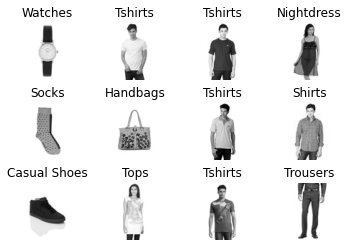

In [ ]:
import matplotlib.image as mpimg
def imshow(img_array, labels, classes):
    _, axs = plt.subplots(3, 4) 
    for i in range(3):
      for j in range(4):
        axs[i][j].imshow(img_array[i * 4 + j], cmap='gray')
        axs[i][j].set_title(classes[labels[i * 4 + j]])
        axs[i][j].axis('off')
    plt.subplots_adjust(hspace=0.4)
    plt.show()

elements = sample(list(dataset), 12)
images = [elem[0] for elem in elements]
labels = [elem[1] for elem in elements]

imshow(images, labels, classes)

In [ ]:
def plot_image_distribution(loader, classes):
    total_category_count = {class_ : 0 for class_ in classes}

    for _, labels in loader:
        total_category_count[ classes[labels] ] += 1

    sorted_classes = list({k: v for k, v in reversed(sorted(total_category_count.items(), key=lambda item: item[1]))}.items())
    x, y = zip(*sorted_classes)
    fig=plt.figure(figsize=(30, 9), dpi= 80, facecolor='w', edgecolor='k')
    plt.rcParams["axes.labelweight"] = "bold"
    plt.rcParams.update({'font.size': 12})
    plt.bar(x, y)
    plt.gca().set_xlim(xmin=-0.5, xmax=len(sorted_classes))
    plt.title("Each Category's Frequency", fontweight="bold")
    plt.xticks(rotation=90)
    plt.yticks(np.arange(0, max(total_category_count.values()) + 200, 200.0))
    plt.xlabel("Categories")
    plt.ylabel("Frequency")
    plt.show()

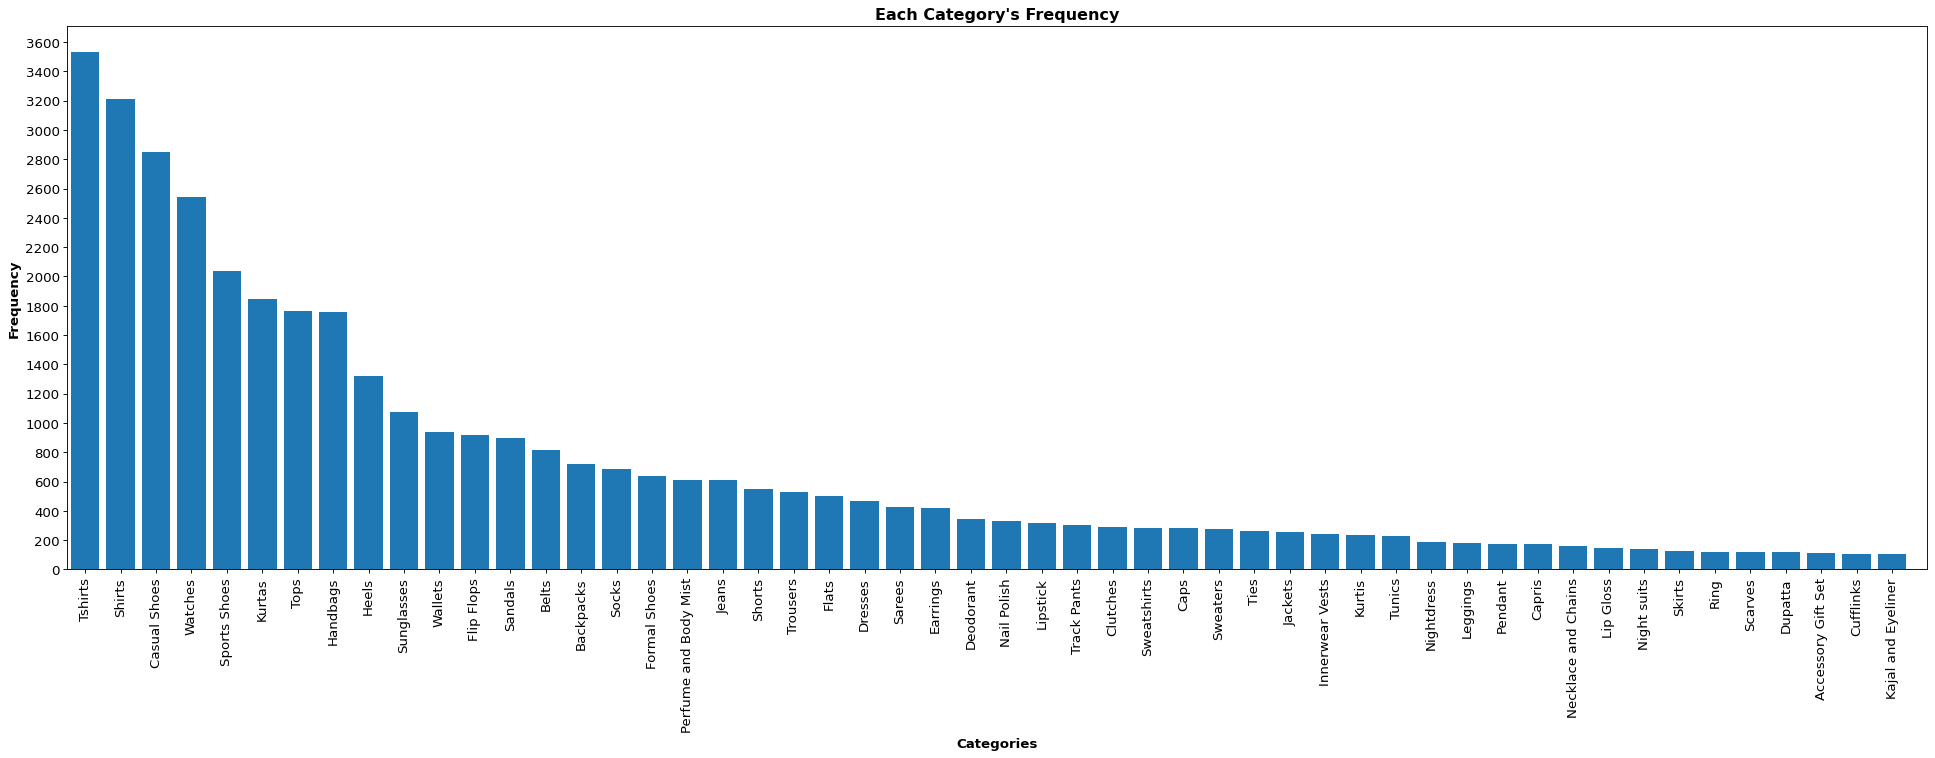

In [ ]:
plot_image_distribution(list(dataset), classes)

In [ ]:
labels = [elem[1] for elem in dataset]
validation_split = 0.2
train_all, test_all, Y_train, Y_test = train_test_split(dataset, labels, test_size=0.2, random_state=42, stratify=labels)

In [ ]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_all, batch_size=batch_size, num_workers=16)
test_loader = torch.utils.data.DataLoader(test_all, batch_size=batch_size, num_workers=16)

In [ ]:
class Model(nn.Module):
    def __init__(self, class_num, act=F.relu):
        super(Model, self).__init__()


        self.layer1 = nn.Linear(1* 60 * 80, 8 * 30 * 40)
        self.act1 = act

        self.layer2 = nn.Linear(8 * 30 * 40, 16 * 15 * 20)
        self.act2 = act

        self.layer3 = nn.Linear(16 * 15 * 20, 48 * 5 * 10)
        self.act3 = act

        self.layer4 = nn.Linear(48 * 5 * 10, 1000)
        self.act4 = act

        self.layer5 = nn.Linear(1000, class_num)

    def forward(self, x):

        x = x.view(x.size(0), -1)

        x = self.layer1(x)
        x = self.act1(x)

        x = self.layer2(x)
        x = self.act2(x)

        x = self.layer3(x)
        x = self.act3(x)

        x = self.layer4(x)
        x = self.act4(x)

        x = self.layer5(x)
        return x

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
print(device)

cuda:0


In [ ]:
model = Model(len(classes))
model = model.to(device)

In [ ]:
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
def fit(model, train_loader, device, criterion, optimizer, num_epochs=10):

  total_time = 0.

  for epoch in range(num_epochs):
      train_loss = 0.
      d1 = datetime.now()
      for images, labels in train_loader:
          
        images = images.to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()
        train_loss += loss.item()

      average_loss = train_loss / len(train_loader)
      d2 = datetime.now()
      delta = d2 - d1
      seconds = float(delta.total_seconds())
      total_time += seconds
      print('epoch %d, train_loss: %.3f, time elapsed: %s seconds' % (epoch + 1, average_loss, seconds))
  print('total training time: %.3f minutes' % (total_time / 60))

In [ ]:
def test_model_accuracy(model, test_loader):
    # Calculate Accuracy         
    correct = 0.
    total = 0.
    # Iterate through test dataset
    with torch.no_grad():
      for images, labels in test_loader:
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.to('cpu') == labels).sum().item()

    accuracy = 100 * correct / total
    print('Accuracy: {}%'.format(accuracy))

In [ ]:
fit(model, train_loader, device, criterion, optimizer)

epoch 1, train_loss: nan, time elapsed: 21.448969 seconds
epoch 2, train_loss: nan, time elapsed: 21.379459 seconds
epoch 3, train_loss: nan, time elapsed: 21.363814 seconds
epoch 4, train_loss: nan, time elapsed: 21.289445 seconds
epoch 5, train_loss: nan, time elapsed: 21.365243 seconds
epoch 6, train_loss: nan, time elapsed: 21.354545 seconds
epoch 7, train_loss: nan, time elapsed: 21.347626 seconds
epoch 8, train_loss: nan, time elapsed: 21.392776 seconds
epoch 9, train_loss: nan, time elapsed: 21.299858 seconds
epoch 10, train_loss: nan, time elapsed: 21.329998 seconds
total training time: 3.560 minutes


In [ ]:
test_model_accuracy(model, test_loader)

Accuracy: 0.2953020134228188%
